In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

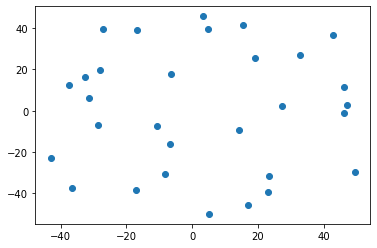

In [79]:
# Number of sensing locations
locations_num = 30

# Size of the map (the map is squared)
map_size = 100.0

# Coordinates of the sensing locations
sensing_locations = (np.random.rand(locations_num, 2) * map_size) - (map_size / 2)

_ = plt.scatter(sensing_locations[:,0], sensing_locations[:,1])

In [80]:
# Number of drones
drones_num = 10

# Length of a single cycle in seconds
cycle_length = 1.0

# Maximum speed of drones in points / seconds
max_speed = 0.5

# Definition of the global state

# Coordinates of the drones locations
drones_locations = np.zeros((drones_num, 2), dtype=float)

# Amounts of sensing data to send per drone
sensing_data_amounts = np.zeros(drones_num, dtype=float)

# AoIs (age of information) per sensing location. Denotes the last cycle in which
# any drone performed sensing at a specific sensing location
aois = np.zeros(locations_num, dtype=int)

# Indices of the chosen locations per drone. They are chosen in the decision cycles.
# The initial values are not significant.
chosen_locations = np.zeros(drones_num, dtype=int)


# Returns the AoI of the given location
def get_location_aoi(cycle, location_index):
    return (cycle * cycle_length) - ((aois[location_index] // cycle_length) * cycle_length)

# Returns the trajectory for the current cycle 
def get_trajectory(drone_index):
    chosen_location_index = chosen_locations[drone_index]
    chosen_location = sensing_locations[chosen_location_index]
    drone_location = drones_locations[drone_index]
    distance = np.linalg.norm(chosen_location - drone_location)
    if distance <= max_speed * cycle_length:
        return chosen_location - drone_location
    else:
        return ((chosen_location - drone_location) / distance) * max_speed * cycle_length

In [81]:
# Simplifying transmission step: only considering a bandwidth and a total amount of
# data for every location. Assumption: tasks are equal, so the amount of data is the same.

# Transmission bandwidth per cycle
bandwidth = 0.5

# Total amount of sensing data per location
total_location_data = 3.0

# Amount of data transmissible per cycle 
data_transmission_cycle = bandwidth * cycle_length

In [82]:
# Number of total cycles for the simulation
cycles_num = 500

# Running simulation (one cycle at a time for every drone)
for cycle in range(1, cycles_num + 1):
    for drone in range(drones_num):
        # TODO: select next location in some way during decision cycle
        aoi = get_location_aoi(cycle, chosen_locations[drone])
        if aoi == cycle_length: # Decision cycle
            pass
        elif (drones_locations[drone] != chosen_locations[drone]).all(): # Empty cycle
            trajectory = get_trajectory(drone)
            new_location = drones_locations[drone] + trajectory
            # Updating drone location
            np.insert(drones_locations, drone, new_location, axis=0)
        elif sensing_data_amounts[drone] == 0.0: # Sensing cycle
            # Updating drone sensing data remaining amount
            np.insert(sensing_data_amounts, drone, total_location_data, axis=0)
        else: # Transmission cycle
            # Updating drone sensing data remaining amount
            np.insert(sensing_data_amounts, drone, 
                np.max(sensing_data_amounts[drone] - data_transmission_cycle, 0.0), axis=0)
            # Updating the AoI if the transmission has been completed
            if sensing_data_amounts[drone] == 0.0:
                np.insert(aois, chosen_locations[drone], cycle, axis=0)

